Import des librairies necessaires :

In [19]:
import os
import sys
import random
import warnings

import pathlib
import numpy as np
import pandas as pd

from skimage.color import rgb2gray

import time

from keras.models import Model, load_model
from keras.layers import Input ,Dropout
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, UpSampling2D,Cropping2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras import metrics

import tensorflow as tf

import cv2
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt

import imageio



Definition des fonctions :

In [16]:
def getData():
    
    folders = []
    training_set = dict()
    idx = 0

    p = pathlib.Path("DATA/train/")

    #Looking for all the folders existing in train folder
    for i in p.glob('*'):
    
        path = "DATA/train/"
        path += i.name;
    
        f_path = pathlib.Path(path)
        folders.append(f_path)


    for p in folders:
    
        im_p = str(p)
        im_p += "/images/"
    
        #First, we set the paths for the image and the masks

        im_path = pathlib.Path(im_p)
    
        #Then, we read the image and the associated mask
        name =""
        for i in im_path.glob('*.png'):
            name = i.name
            if name == "mask.png":
                mask_path = im_p + name
                mask = imageio.imread(mask_path)
            else:
                image_path = im_p + name
                im = imageio.imread(image_path)
    

    
        training_set[idx] = (im[:,:,0], mask)
        idx += 1


    return idx, training_set


In [3]:
def perlin(x,y,seed=0):
    # permutation table
    np.random.seed(seed)
    p = np.arange(256,dtype=int)
    np.random.shuffle(p)
    p = np.stack([p,p]).flatten()
    # coordinates of the top-left
    xi = x.astype(int)
    yi = y.astype(int)
    # internal coordinates
    xf = x - xi
    yf = y - yi
    # fade factors
    u = fade(xf)
    v = fade(yf)
    # noise components
    n00 = gradient(p[p[xi]+yi],xf,yf)
    n01 = gradient(p[p[xi]+yi+1],xf,yf-1)
    n11 = gradient(p[p[xi+1]+yi+1],xf-1,yf-1)
    n10 = gradient(p[p[xi+1]+yi],xf-1,yf)
    # combine noises
    x1 = lerp(n00,n10,u)
    x2 = lerp(n01,n11,u) 
    return lerp(x1,x2,v) 

def lerp(a,b,x):
    "linear interpolation"
    return a + x * (b-a)

def fade(t):
    "6t^5 - 15t^4 + 10t^3"
    return 6 * t**5 - 15 * t**4 + 10 * t**3

def gradient(h,x,y):
    "grad converts h to the right gradient vector and return the dot product with (x,y)"
    vectors = np.array([[0,1],[0,-1],[1,0],[-1,0]])
    g = vectors[h%4]
    return g[:,:,0] * x + g[:,:,1] * y

lin = np.linspace(0,2,256,endpoint=False)
x,y = np.meshgrid(lin,lin)

im_p = perlin(x,y,seed=random.randint(5,20))

In [4]:
def elastic_transform(image, alpha, sigma, alpha_affine, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_ (with modifications).
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
         Convolutional Neural Networks applied to Visual Document Analysis", in
         Proc. of the International Conference on Document Analysis and
         Recognition, 2003.

     Based on https://gist.github.com/erniejunior/601cdf56d2b424757de5
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    shape_size = shape[:2]
    
    # Random affine
    center_square = np.float32(shape_size) // 2
    square_size = min(shape_size) // 3
    pts1 = np.float32([center_square + square_size, [center_square[0]+square_size, center_square[1]-square_size], center_square - square_size])
    pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, shape_size, image,borderMode=cv2.BORDER_REFLECT_101)
    
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dz = np.zeros_like(dx)

    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))

    return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)



def draw_grid(im, grid_size):
    # Draw grid lines
    for i in range(0, im.shape[1], grid_size):
        cv2.line(im, (i, 0), (i, im.shape[0]), color=(255,))
    for j in range(0, im.shape[0], grid_size):
        cv2.line(im, (0, j), (im.shape[1], j), color=(255,))


In [23]:
def createUnet(height,width,depth,kernel):
    dropoutRate = 0.2
    inputLayer = Input(( height, width, depth))

    normalise = Lambda(lambda x: x / 255) (inputLayer)

    conv11 = Conv2D(16, kernel, padding='valid', activation='relu', kernel_initializer='random_uniform')(normalise)
    drop1 = Dropout(dropoutRate, noise_shape=None, seed=None)(conv11)
    conv12 = Conv2D(16, kernel, padding='valid', activation='relu', kernel_initializer='random_uniform')(drop1)
    
    pool1 = MaxPooling2D((2,2))(conv12)
    conv21 = Conv2D(32, kernel, padding='valid', activation='relu', kernel_initializer='random_uniform')(pool1)
    drop3 = Dropout(dropoutRate, noise_shape=None, seed=None)(conv21)
    conv22 = Conv2D(32, kernel, padding='valid', activation='relu', kernel_initializer='random_uniform')(drop3)
    
    pool2 = MaxPooling2D((2,2))(conv22)
    conv31 = Conv2D(64, kernel, padding='valid', activation='relu', kernel_initializer='random_uniform')(pool2)
    drop5 = Dropout(dropoutRate, noise_shape=None, seed=None)(conv31)
    conv32 = Conv2D(64, kernel, padding='valid', activation='relu', kernel_initializer='random_uniform')(drop5)
    
    pool3 = MaxPooling2D((2,2))(conv32)
    conv41 = Conv2D(128, kernel, padding='valid', activation='relu', kernel_initializer='random_uniform')(pool3)
    drop7 = Dropout(dropoutRate, noise_shape=None, seed=None)(conv41)
    conv42 = Conv2D(128, kernel, padding='valid', activation='relu', kernel_initializer='random_uniform')(drop7)
    
    pool4 = MaxPooling2D((2,2))(conv42)
    conv51 = Conv2D(256, kernel, padding='valid', activation='relu', kernel_initializer='random_uniform')(pool4)
    drop9 = Dropout(dropoutRate, noise_shape=None, seed=None)(conv51)
    conv52 = Conv2D(256, kernel, padding='valid', activation='relu', kernel_initializer='random_uniform')(drop9)
    


    upconv1 = UpSampling2D(size=(2, 2))(conv52)
    ch, cw = get_crop_shape(conv42, upconv1)
    cropconv4 = Cropping2D(cropping=(ch,cw))(conv42)
    up1   = concatenate([upconv1, cropconv4], axis=3)
    conv61 = Conv2D(128, kernel, padding="valid", activation="relu", kernel_initializer='random_uniform')(up1)
    drop11 = Dropout(dropoutRate, noise_shape=None, seed=None)(conv61)
    conv62 = Conv2D(128, kernel, padding="valid", activation="relu", kernel_initializer='random_uniform')(drop11)
    

    upconv2 = UpSampling2D(size=(2, 2))(conv62)
    ch, cw = get_crop_shape(conv32, upconv2)
    cropconv3 = Cropping2D(cropping=(ch,cw))(conv32)
    up2  = concatenate([upconv2, cropconv3], axis=3)
    conv71 = Conv2D(64, kernel, padding="valid", activation="relu", kernel_initializer='random_uniform')(up2)
    drop13 = Dropout(dropoutRate, noise_shape=None, seed=None)(conv71)
    conv72 = Conv2D(64, kernel, padding="valid", activation="relu", kernel_initializer='random_uniform')(drop13)
    

    upconv3 = UpSampling2D(size=(2, 2))(conv72)
    ch, cw = get_crop_shape(conv22, upconv3)
    cropconv2 = Cropping2D(cropping=(ch,cw))(conv22)
    up3  = concatenate([upconv3, cropconv2], axis=3)
    conv81 = Conv2D(32, kernel, padding="valid", activation="relu", kernel_initializer='random_uniform')(up3)
    drop15 = Dropout(dropoutRate, noise_shape=None, seed=None)(conv81)
    conv82 = Conv2D(32, kernel, padding="valid", activation="relu", kernel_initializer='random_uniform')(drop15)
    
    upconv4 = UpSampling2D(size=(2, 2))(conv82)
    ch, cw = get_crop_shape(conv12, upconv4)
    cropconv1 = Cropping2D(cropping=(ch,cw))(conv12)
    up4  = concatenate([upconv4, cropconv1], axis=3)
    conv91 = Conv2D(16, kernel, padding="valid", activation="relu", kernel_initializer='random_uniform')(up4)
    drop17 = Dropout(dropoutRate, noise_shape=None, seed=None)(conv91)
    conv92 = Conv2D(16, kernel, padding="valid", activation="relu", kernel_initializer='random_uniform')(drop17)

    outputconv = Conv2D(1, (1, 1), activation="sigmoid")(conv92)


    u_net = Model(inputs= inputLayer, outputs = outputconv)
    return u_net

In [14]:
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
        return v
    return v / norm

def elastoperlin_transformation(im ,mask,elast, perl, shape):
    lina = np.linspace(0,1,shape[0],endpoint=False)
    linb = np.linspace(0,1,shape[1],endpoint=False)
    a,b = np.meshgrid(linb,lina)
    if perl:
        im_p = perlin(a,b,seed=random.randint(1,20000))
        im_p = np.abs(im_p)
        im_p = np.array((normalize(im_p)*255), dtype = np.uint8)
        #im_p = np.concatenate((im_p[...,None], im_p[...,None],im_p[...,None]), axis=2)
        im = im + im_p
    if elast:
        print np.shape(im)
        im = np.concatenate((im[...,None], mask[...,None]), axis=2)
        im = elastic_transform(im,im.shape[1]*2,im.shape[1]*0.1,im.shape[1]*0.08) 
        mask = im[:,:,1:]
        im = im[:,:,0]
    im = cv2.copyMakeBorder(im,92,92,92,92,cv2.BORDER_REFLECT) 
    # 92 représente la marge rognée par les convolutions successives
    return im, mask

In [7]:
def imaskdivision(im,mask,shape, padding):
    # padding est la taille de la marge non masquée (92)
    # shape est la shape maximale d'un echantillon (132,132) dans notre cas
    ims = []
    masks = []
    widthDiv = int(np.ceil(float(im.shape[0]-(2*padding))/float(shape[0])))
    heightDiv = int(np.ceil(float(im.shape[1]-(2*padding))/float(shape[1])))
    for i in range(widthDiv):
        for j in range(heightDiv):
            if i == widthDiv-1:
                sw = im.shape[0]-(shape[0]+padding)
            else:
                sw = padding + shape[0]*i
                
            if j == heightDiv-1:
                sh = im.shape[1]-(shape[1]+padding)
            else:
                sh = padding + shape[1]*j
            
            imseg = im[sw-padding:sw+shape[0]+padding,sh-padding:sh+shape[1]+padding]
            ims.append(imseg)
            maskseg = mask[sw-padding:sw+shape[0]-padding,sh-padding:sh+shape[1]-padding]
            maskseg = (maskseg>0)
            masks.append(maskseg)
    return ims,masks

def dataAugmentation(im, mask, rate):
    train = []
    labels = []
    for i in range(rate):
        imtemp, masktemp = elastoperlin_transformation(im, mask, True, False,np.shape(im))
        ims, masks = imaskdivision(imtemp, masktemp,(132,132),92)
        for image in ims:
            train.append(image)
        for m in masks:
            labels.append(m)
    return train , labels        
    
        

In [8]:
def trainDatas(training_set, nbIms,rate):
    train = []
    labels = []

    for i in range(nbIms):
        im, mask = training_set[i]
        ims , masks = dataAugmentation(im,mask,rate)
        print i, " images traitées"
        for image in ims:
            train.append(np.reshape(image,(316,316,1)))
        for m in masks:
            labels.append(np.reshape(m, (132,132,1)))
    train = np.array(train)
    labels = np.array(labels)
    return train ,labels


In [9]:
def get_crop_shape(target, refer):
        # width, the 3rd dimension
        cw = (target.get_shape()[2] - refer.get_shape()[2]).value
        assert (cw >= 0)
        if cw % 2 != 0:
            cw1, cw2 = int(cw/2), int(cw/2) + 1
        else:
            cw1, cw2 = int(cw/2), int(cw/2)
        # height, the 2nd dimension
        ch = (target.get_shape()[1] - refer.get_shape()[1]).value
        assert (ch >= 0)
        if ch % 2 != 0:
            ch1, ch2 = int(ch/2), int(ch/2) + 1
        else:
            ch1, ch2 = int(ch/2), int(ch/2)

        return (ch1, ch2), (cw1, cw2)

In [10]:
def weightLoss(y_true, y_pred):
    [mask, weight] = tf.unstack(y_true, 2, axis=3)
    weighted_pred = y_pred*weight
    weighted_mask = mask*weight
    return binary_crossentropy(weighted_mask, weighted_pred)

Récupération des images et creation du dataset

In [17]:
nbImagesUsables,trainingData = getData()
imagesUsed = 6
augDim = 1
train, labels = trainDatas(trainingData,imagesUsed,augDim)
del trainingData



(256, 256)
0  images traitées
(256, 256)
1  images traitées
(256, 256)
2  images traitées
(256, 256)
3  images traitées
(256, 256)
4  images traitées
(520, 696)
5  images traitées


creation  du réseau et définition de la perte

In [21]:
# Initialisation des variables
height = 316
width = 316
depth = 1
kernel= (3,3)

In [24]:
u_net = createUnet(height,width,depth,kernel)
u_net.compile(optimizer='adam', loss='binary_crossentropy', metrics =[metrics.binary_accuracy])
u_net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 316, 316, 1)  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 316, 316, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 314, 314, 16) 160         lambda_2[0][0]                   
__________________________________________________________________________________________________
dropout_13 (Dropout)            (None, 314, 314, 16) 0           conv2d_13[0][0]                  
__________________________________________________________________________________________________
conv2d_14 

Entrainement

In [25]:
earlystopper = EarlyStopping(patience=4, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018.h5', verbose=1, save_best_only=True)
results = u_net.fit(train, labels, validation_split=0.2, batch_size=4, epochs=15, 
                    callbacks=[earlystopper, checkpointer])

Train on 35 samples, validate on 9 samples
Epoch 1/15
35/35 [==============================] - 23s 667ms/step - loss: 0.6516 - binary_accuracy: 0.8604 - val_loss: 0.6382 - val_binary_accuracy: 0.6838

Epoch 00001: val_loss improved from inf to 0.63819, saving model to model-dsbowl2018.h5
Epoch 2/15
35/35 [==============================] - 22s 621ms/step - loss: 0.4223 - binary_accuracy: 0.8624 - val_loss: 0.6223 - val_binary_accuracy: 0.6838

Epoch 00002: val_loss improved from 0.63819 to 0.62227, saving model to model-dsbowl2018.h5
Epoch 3/15
35/35 [==============================] - 22s 620ms/step - loss: 0.4517 - binary_accuracy: 0.8624 - val_loss: 0.5941 - val_binary_accuracy: 0.6838

Epoch 00003: val_loss improved from 0.62227 to 0.59411, saving model to model-dsbowl2018.h5
Epoch 4/15
35/35 [==============================] - 23s 643ms/step - loss: 0.4071 - binary_accuracy: 0.8624 - val_loss: 0.7275 - val_binary_accuracy: 0.6838

Epoch 00004: val_loss did not improve
Epoch 5/15
35/3

Prédiction et visualisation

In [26]:
p_test = u_net.predict(train, batch_size = 1, verbose=1)

44/44 [==============================] - 8s 178ms/step


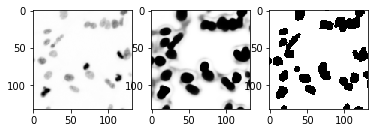

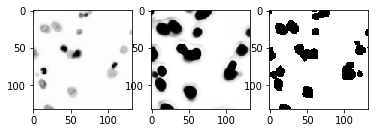

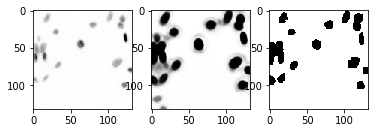

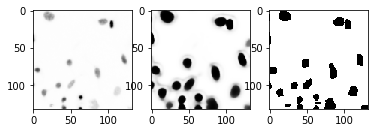

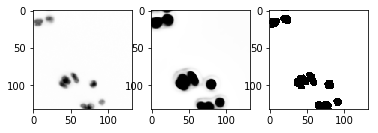

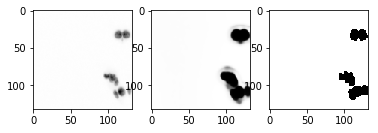

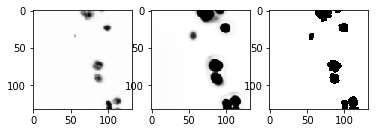

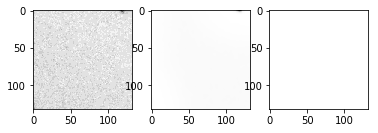

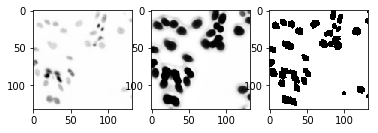

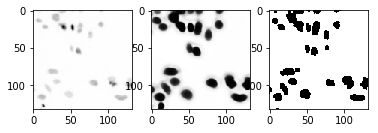

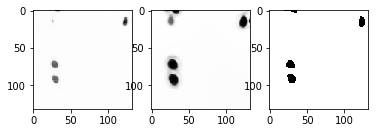

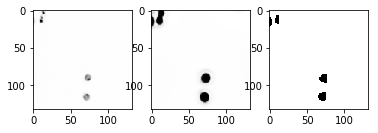

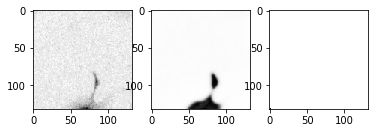

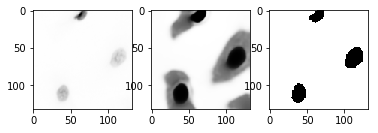

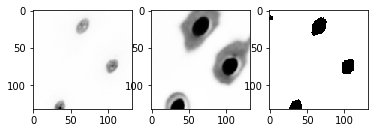

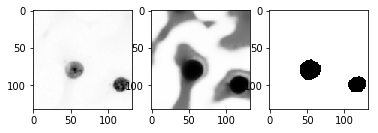

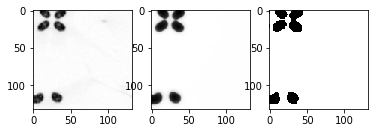

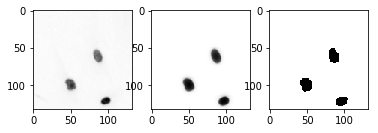

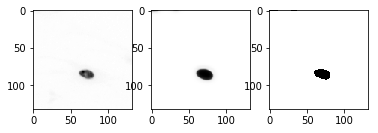

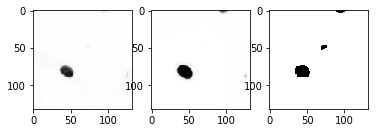

In [27]:
for k in range(20):
    
    plt.figure(1)
    
    plt.subplot(131)
    plt.imshow(train[k,92:224,92:224,0], interpolation="nearest",cmap ="Greys")
    plt.subplot(132)
    plt.imshow(np.reshape((p_test[k]),(132,132)), interpolation="nearest",cmap ="Greys")

    plt.subplot(133)
    plt.imshow(np.reshape(labels[k],(132,132)),interpolation="nearest",cmap ="Greys")
    plt.show()
